# StakingRewards Analysis

Notebook contains the data analysis for the project work:
**Measuring Validator Concentration in Proof-of-Stake Networks**

- Note: Recommended run flow: (1) start Docker, (2) run `./run_jupyter.sh`, (3) then open the Jupyter URL from the terminal.


In [1]:
# Imports
import requests
import json
import pandas as pd
import numpy as np
from pprint import pprint

In [2]:
# Pandas Options
pd.options.display.float_format = "{:,.2f}".format
pd.set_option("display.max_rows", 300)

In [3]:
# Query stakingrewards token status
from Helper import StakingRewardsAPIClient

client = StakingRewardsAPIClient()
status = client.get_billing_status()
pprint(status)

{'available_credits': 1239984,
 'billing_date': '2026-02-18T13:27:47.137364Z',
 'monthly_quota': 1500000,
 'plan_name': 'startup yearly v0',
 'requests_allowed': True,
 'subscribed_at': '2025-11-24T07:32:41Z'}


In [4]:
# List all available assets, limit to 1B market cap
MIN_MARKET_CAP = 1_000_000_000

metrics_col = [
    "marketcap",
    "price",
    "active_validators",
    "real_reward_rate",
    "reward_rate",
    "staked_tokens",
    "staking_ratio",
    "total_staking_wallets",
    "total_validators"
]

metric_keys_str = ", ".join(f'"{m}"' for m in metrics_col)

query = f"""
{{
  assets(limit: 150) {{
    slug
    id
    metrics(
      where: {{ metricKeys: [{metric_keys_str}] }},
      limit: {len(metrics_col)}
    ) {{
      metricKey
      label
      defaultValue
    }}
  }}
}}
"""
result = client.execute_raw_query(query)

assets = result["data"]["assets"]

rows = []

for asset in assets:
    # metrics can be None -> normalize to []
    metrics_list = asset.get("metrics") or []

    # extra safety in case the API returns something unexpected
    if not isinstance(metrics_list, list):
        metrics_list = []

    metric_map = {}
    for m in metrics_list:
        if not isinstance(m, dict):
            continue
        key = m.get("metricKey")
        if not key:
            continue
        metric_map[key] = m.get("defaultValue")

    row = {"asset": asset.get("slug")}
    for k in metrics_col:
        # if a metric isn't available, this becomes None/NaN in pandas (fine)
        row[k] = metric_map.get(k)

    rows.append(row)

df = pd.DataFrame(rows)
df = df.sort_values("marketcap", ascending=False)

column_order = ["asset"] + metrics_col
df = df.reindex(columns=column_order)
filtered_df = df[
    (df["marketcap"] >= 500_000_000) &
    (df["active_validators"] > 10)
]

filtered_df.head()
filtered_df.describe()
filtered_df.set_index("asset")

#Assets available on Rated Network
#ethereum-2-0
#solana
#cardano
#avalanche
#polkadot
#cosmos
#near-protocol
#tezos
#aptos
#sui

,marketcap,price,active_validators,real_reward_rate,reward_rate,staked_tokens,staking_ratio,total_staking_wallets,total_validators
asset,,,,,,,,,
ethereum-2-0,"251,798,631,941.20","2,086.28","928,044.00",1.96,2.84,"36,948,045.27",30.61,"928,044.00","966,988.00"
binance-smart-chain,"86,652,062,072.20",635.46,45.00,7.67,1.65,"25,712,726.57",18.86,"12,709.00",45.00
solana,"50,888,408,579.34",89.60,785.00,1.80,6.29,"418,071,241.73",67.42,"1,242,625.00","6,780.00"
tron,"26,674,145,518.99",0.28,27.00,NaN,3.24,"44,172,266,014.00",46.63,"314,790.00",432.00
staked-ether,"19,882,620,408.73","2,086.33","249,436.00",1.49,2.37,"9,525,694.57",NaN,"589,847.00","249,436.60"
cardano,"10,968,291,555.99",0.30,964.00,0.61,2.27,"21,331,418,207.34",57.47,"1,286,275.00","2,916.00"
hedera-hashgraph,"4,514,511,050.24",0.10,32.00,2.11,2.48,"16,006,445,971.00",32.01,"124,107.00",32.00
avalanche,"4,171,267,638.17",9.66,718.00,3.11,6.99,"232,433,249.40",49.60,"31,685.00",718.00
sui,"3,966,239,498.20",1.03,125.00,-1.56,1.73,"7,430,633,619.56",74.31,0.00,125.00


In [5]:
# Reward options for assets token
def build_staking_type_availability_table(asset_slugs: list[str]) -> pd.DataFrame:
    """
    Build a dataframe showing which staking types are available per asset.

    Args:
        asset_slugs: List of asset slugs

    Returns:
        Pandas DataFrame with asset as first column and staking types as columns
    """
    rows = []
    all_types = set()

    # First pass: collect available types per asset
    asset_to_types = {}

    for asset in asset_slugs:
        types = client.discover_reward_option_types(asset)
        keys = {t["key"] for t in types if "key" in t}
        asset_to_types[asset] = keys
        all_types.update(keys)

    # Sort staking types for stable column order
    sorted_types = sorted(all_types)

    # Second pass: build rows
    for asset in asset_slugs:
        row = {"asset": asset}
        asset_types = asset_to_types.get(asset, set())

        for t in sorted_types:
            row[t] = "✓" if t in asset_types else ""

        rows.append(row)

    df = pd.DataFrame(rows)
    return df

staking_types = build_staking_type_availability_table(filtered_df['asset'].astype(str).tolist())
display(staking_types)

,asset,actively-validated-service,custodial,hosting,lending,liquid-staking,operator,partial-staking,pos,smart-contract,solo-staking
0,ethereum-2-0,✓,✓,✓,✓,✓,✓,✓,,✓,✓
1,binance-smart-chain,,✓,,,,,,✓,,✓
2,solana,,✓,,,✓,,,✓,,
3,tron,,✓,✓,,,,,✓,,✓
4,staked-ether,✓,,,,,,,,✓,
5,cardano,,,,,,,,✓,,
6,hedera-hashgraph,,,,,,,,✓,✓,✓
7,avalanche,,✓,✓,,✓,,,✓,,
8,sui,,✓,,,✓,,,✓,,✓
9,crypto-com-coin,,,✓,,,,,✓,,✓


In [6]:
# Staked token amounts by type for assets
def _extract_rows(resp):
    """
    Normalize common API response shapes into a list of row dicts.
    Supports: list[...] or dict{"data": [...]} or dict{"results":[...]} etc.
    """
    if resp is None:
        return []
    if isinstance(resp, list):
        return resp
    if isinstance(resp, dict):
        for k in ("data", "results", "items"):
            if k in resp and isinstance(resp[k], list):
                return resp[k]
    return []

def build_provider_stake_shares_table(
    asset_slugs: list[str],
    client,
    limit: int = 200,
    is_active: bool = True,
    include_reward_rate: bool = True,
    use_cache: bool = True,
    cell_metric: str = "total_staked_tokens",
    show_percentages: bool = False
) -> pd.DataFrame:
    """
    Build a dataframe with assets as rows, type_keys as columns, numeric cell values per (asset, type),
    plus a final 'total' column.

    cell_metric:
      - "provider_count": number of providers returned by get_provider_stake_shares
      - "total_staked_tokens": sum of stake-share-like fields if present (fallback to provider_count)
    """
    asset_to_types: dict[str, set[str]] = {}
    all_types: set[str] = set()

    for asset in asset_slugs:
        types = client.discover_reward_option_types(asset)
        keys = {t.get("key") for t in (types or []) if isinstance(t, dict) and t.get("key")}
        asset_to_types[asset] = set(keys)
        all_types.update(keys)

    sorted_types = sorted(all_types)

    rows = []
    for asset in asset_slugs:
        supported = asset_to_types.get(asset, set())
        row = {"asset": asset}

        total = 0
        for t in sorted_types:
            if t not in supported:
                row[t] = "X"
                continue

            try:
                resp = client.get_provider_stake_shares(
                    asset_slug=asset,
                    limit=limit,
                    is_active=is_active,
                    include_reward_rate=include_reward_rate,
                    use_cache=use_cache,
                    type_keys=[t],  # pass the single type key
                )
            except Exception as e:
                # If the API errors for a supported type, capture a readable marker
                row[t] = f"error: {type(e).__name__}"
                continue

            if cell_metric == "provider_count":
                numeric_vals = []
                for t in sorted_types:
                    v = row.get(t)
                    if isinstance(v, (int, float, np.integer, np.floating)):
                        numeric_vals.append(float(v))
                total = float(np.sum(numeric_vals)) if numeric_vals else 0.0
                no_of_providers = len(resp['providers'])
                if show_percentages:
                    if total > 0:
                        row[t] = no_of_providers / total
                    else:
                        row[t] = 0
                else:
                    row[t] = no_of_providers


            elif cell_metric == "total_staked_tokens":
                sum_of_staked = sum(
                    p.get("staked_tokens", 0)
                    for p in resp.get("providers", [])
                    if p.get("staked_tokens") is not None
                )
                total = resp['total_staked_tokens']
                if show_percentages:
                    if total > 0:
                        row[t] = sum_of_staked / total
                    else:
                        row[t] = 0
                else:
                    row[t] = sum_of_staked
            else:
                raise ValueError("cell_metric must be 'provider_count' or 'stake_share_sum'")

        row['total'] = total
        rows.append(row)

    df = pd.DataFrame(rows)
    return df

asset_slugs = filtered_df["asset"].astype(str).tolist()
stake_shares_table = build_provider_stake_shares_table(
    asset_slugs=asset_slugs,
    client=client,
    cell_metric="total_staked_tokens",
    show_percentages=True # Flip if you want absolute values
)
display(stake_shares_table)

,asset,actively-validated-service,custodial,hosting,lending,liquid-staking,operator,partial-staking,pos,smart-contract,solo-staking,total
0,ethereum-2-0,0.01,0.00,0.11,0.00,0.50,0.39,0.00,X,0.88,0.00,"36,948,045.27"
1,binance-smart-chain,X,0.00,X,X,X,X,X,1.00,X,0.00,"25,712,726.57"
2,solana,X,0.00,X,X,0.07,X,X,0.35,X,X,"418,071,241.73"
3,tron,X,0.00,0.00,X,X,X,X,0.98,X,0.00,"44,172,266,014.00"
4,staked-ether,0.05,X,X,X,X,X,X,X,0.00,X,"9,525,694.57"
5,cardano,X,X,X,X,X,X,X,0.65,X,X,"21,331,418,207.34"
6,hedera-hashgraph,X,X,X,X,X,X,X,0.87,0.03,0.00,"16,006,445,971.00"
7,avalanche,X,0.00,0.07,X,0.12,X,X,0.11,X,X,"232,433,249.40"
8,sui,X,0.00,X,X,0.00,X,X,1.00,X,0.00,"7,430,633,619.56"
9,crypto-com-coin,X,X,0.00,X,X,X,X,0.94,X,0.00,"13,353,737,324.17"


In [7]:
def _build_stake_values_with_residual(
    providers: list[dict],
    total_value: float,
    split_residual: bool = True,
    min_residual_token_amount: float = 1.0,
) -> tuple[list[float], float, float]:
    if total_value <= 0:
        return [], 0.0, 0.0

    if min_residual_token_amount <= 0:
        raise ValueError("min_residual_token_amount must be > 0")

    values: list[float] = []
    tracked_total = 0.0
    max_residual_chunks = 10000

    for p in providers:
        raw_value = p.get("value")
        if raw_value is None:
            raw_value = p.get("staked_tokens")
        if raw_value is None:
            continue
        value = float(raw_value)
        if value <= 0:
            continue
        values.append(value)
        tracked_total += value

    residual = max(total_value - tracked_total, 0.0)

    if residual > 0:
        if split_residual:
            n_full = int(residual // min_residual_token_amount)
            if n_full > max_residual_chunks:
                chunk_value = residual / max_residual_chunks
                values.extend([chunk_value] * max_residual_chunks)
            else:
                remainder = residual - (n_full * min_residual_token_amount)
                if n_full > 0:
                    values.extend([min_residual_token_amount] * n_full)
                if remainder > 0:
                    values.append(remainder)
        else:
            values.append(residual)

    return values, tracked_total, residual

def calculate_hhi_from_values(
    providers: list[dict],
    total_value: float,
    split_residual: bool = True,
    min_residual_token_amount: float = 1.0,
) -> float:
    """
    Calculate the Herfindahl–Hirschman Index (HHI) from absolute values.

    Args:
        providers: List of dicts (e.g. staking providers or categories)
        total_value: Total staking amount for the network
        split_residual: If True, split residual into min token chunks. If False, use one residual blob.
        min_residual_token_amount: Minimum chunk size for residual splitting

    Returns:
        HHI value in the range [0, 1]
    """
    if total_value <= 0:
        return 0.0

    values, _, _ = _build_stake_values_with_residual(
        providers=providers,
        total_value=total_value,
        split_residual=split_residual,
        min_residual_token_amount=min_residual_token_amount,
    )

    hhi = 0.0
    for value in values:
        share = value / total_value
        hhi += share ** 2

    return hhi

def calculate_hhi_from_staking_shares_response(
    response: dict,
    split_residual: bool = True,
    min_residual_token_amount: float = 1.0,
):
    return calculate_hhi_from_values(
        response["providers"],
        response["total_staked_tokens"],
        split_residual=split_residual,
        min_residual_token_amount=min_residual_token_amount,
    )

In [8]:
def calculate_nakamoto_coefficient(
    providers: list[dict],
    total_value: float,
    threshold: float = 0.33,
    split_residual: bool = True,
    min_residual_token_amount: float = 1.0,
) -> int | None:
    """
    Calculate the Nakamoto coefficient given partial provider coverage.

    Args:
        providers: List of provider dicts
        total_value: Total network stake
        threshold: Control threshold (e.g. 0.33 or 0.50)
        split_residual: If True, split residual into min token chunks. If False, use one residual blob.
        min_residual_token_amount: Minimum chunk size for residual splitting

    Returns:
        Nakamoto coefficient (int), or None if not computable
    """
    if total_value <= 0:
        return None

    stakes, _, _ = _build_stake_values_with_residual(
        providers=providers,
        total_value=total_value,
        split_residual=split_residual,
        min_residual_token_amount=min_residual_token_amount,
    )

    stakes.sort(reverse=True)

    cumulative = 0.0
    for i, stake in enumerate(stakes, start=1):
        cumulative += stake
        if cumulative / total_value >= threshold:
            return i

    return None

def calculate_nakamoto_coefficient_from_staking_shares_response(
    response: dict,
    threshold: float = 0.33,
    split_residual: bool = True,
    min_residual_token_amount: float = 1.0,
):
    return calculate_nakamoto_coefficient(
        response["providers"],
        response["total_staked_tokens"],
        threshold=threshold,
        split_residual=split_residual,
        min_residual_token_amount=min_residual_token_amount,
    )

In [9]:
# top-k stake shares
def calculate_top_k_stake_shares(
    providers: list[dict],
    total_value: float,
    k_values: list[int],
    split_residual: bool = True,
    min_residual_token_amount: float = 1.0,
) -> dict:
    """
    Calculate top-k stake shares relative to total network stake.

    Args:
        providers: List of provider dicts
        total_value: Total network stake
        k_values: List of k values (e.g. [1, 3, 5, 10])
        split_residual: If True, split residual into min token chunks. If False, use one residual blob.
        min_residual_token_amount: Minimum chunk size for residual splitting

    Returns:
        Dict containing top-k shares and diagnostics
    """
    if total_value <= 0:
        return {
            "top_k": {},
            "tracked_total": 0.0,
            "residual": 0.0,
            "coverage": 0.0,
            "entity_count": 0
        }

    stakes, tracked_total, residual = _build_stake_values_with_residual(
        providers=providers,
        total_value=total_value,
        split_residual=split_residual,
        min_residual_token_amount=min_residual_token_amount,
    )

    stakes.sort(reverse=True)

    top_k = {}
    cumulative = 0.0
    max_k = max(k_values)

    prefix = []
    for s in stakes[:max_k]:
        cumulative += s
        prefix.append(cumulative)

    for k in k_values:
        if k <= 0:
            continue
        if k > len(stakes):
            top_k[str(k)] = sum(stakes) / total_value
        else:
            top_k[str(k)] = prefix[k - 1] / total_value

    return {
        "top_k": top_k,
        "tracked_total": tracked_total,
        "residual": residual,
        "coverage": tracked_total / total_value,
        "entity_count": len(stakes),
        "split_residual": split_residual,
        "min_residual_token_amount": min_residual_token_amount
    }

def calculate_top_k_stake_shares_from_staking_shares_response(
    response: dict,
    k_values: list[int] | None = None,
    split_residual: bool = True,
    min_residual_token_amount: float = 1.0,
):
    if k_values is None:
        k_values = [1, 3, 4]
    return calculate_top_k_stake_shares(
        response["providers"],
        response["total_staked_tokens"],
        k_values=k_values,
        split_residual=split_residual,
        min_residual_token_amount=min_residual_token_amount,
    )

In [10]:
def calculate_gini_from_values(
    providers: list[dict],
    total_value: float,
    split_residual: bool = True,
    min_residual_token_amount: float = 1.0,
) -> float:
    """
    Calculate the Gini coefficient from absolute values.

    Args:
        providers: List of dicts (e.g. staking providers or categories)
        total_value: Total staking amount for the network
        split_residual: If True, split residual into min token chunks. If False, use one residual blob.
        min_residual_token_amount: Minimum chunk size for residual splitting

    Returns:
        Gini coefficient in the range [0, 1]
    """
    if total_value <= 0:
        return 0.0

    values, _, _ = _build_stake_values_with_residual(
        providers=providers,
        total_value=total_value,
        split_residual=split_residual,
        min_residual_token_amount=min_residual_token_amount,
    )

    n = len(values)
    if n == 0:
        return 0.0

    values.sort()

    # G = (2 * sum(i * x_i)) / (n * sum(x_i)) - (n + 1) / n
    weighted_sum = 0.0
    for i, v in enumerate(values, start=1):
        weighted_sum += i * v

    gini = (2.0 * weighted_sum) / (n * sum(values)) - (n + 1.0) / n

    return max(0.0, min(1.0, gini))

In [30]:
## Create table with metrics of the asset classes
rows = []
provider_asset_rows = []
lorenz_inputs = {}

INCLUDED_TYPES = {
    "actively-validated-service",
    "hosting",
    "liquid-staking",
    "operator",
    "partial-staking",
    "solo-staking",
    "pos",
}

EXCLUDED_TYPES = {
    "custodial",
    "lending",
    "smart-contract",
}

RESIDUAL_SPLIT_FOR_METRICS = False
RESIDUAL_MIN_TOKEN_AMOUNT = 32.0

def to_float(x, default=0.0):
    if x is None:
        return default
    try:
        if isinstance(x, str):
            x = x.replace(",", "").strip()
            if x == "":
                return default
        return float(x)
    except (TypeError, ValueError):
        return default


def collapse_providers_max(per_type_rows):
    """
    Collapse provider-role rows into one row per provider with:
      value = max(staked_tokens) across included types for that provider.
    """
    by_provider = {}

    for p in per_type_rows:
        provider_key = p.get("provider")
        if not provider_key:
            continue

        v = to_float(p.get("staked_tokens", 0.0))
        cur = by_provider.get(provider_key)

        if cur is None:
            by_provider[provider_key] = {
                **p,
                "value": v,
            }
        elif v > cur["value"]:
            cur["value"] = v
            for k, val in p.items():
                cur[k] = val

    return list(by_provider.values())


for asset in filtered_df["asset"]:
    resp = client.get_provider_stake_shares(
        asset_slug=asset,
        limit=300,
        is_active=True,
        include_reward_rate=True,
    )

    providers = resp.get("providers", [])
    if not providers:
        continue

    total_value = to_float(resp.get("total_staked_tokens", 0.0))
    if total_value <= 0:
        continue

    providers_clean = [
        p for p in providers
        if p.get("reward_option_type_key") not in EXCLUDED_TYPES
    ]

    filtered_providers = [
        p for p in providers_clean
        if (
            p.get("reward_option_type_key") in INCLUDED_TYPES
            and to_float(p.get("staked_tokens", 0.0)) > 0.0
        )
    ]

    metric_providers = collapse_providers_max(filtered_providers)
    included_sum = sum(p["value"] for p in metric_providers)
    provider_count = len(metric_providers)

    coverage_included = included_sum / total_value

    gini = calculate_gini_from_values(
        metric_providers,
        total_value,
        split_residual=RESIDUAL_SPLIT_FOR_METRICS,
        min_residual_token_amount=RESIDUAL_MIN_TOKEN_AMOUNT,
    )

    nakamoto = calculate_nakamoto_coefficient(
        metric_providers,
        total_value=total_value,
        threshold=0.33,
        split_residual=RESIDUAL_SPLIT_FOR_METRICS,
        min_residual_token_amount=RESIDUAL_MIN_TOKEN_AMOUNT,
    )

    hhi = calculate_hhi_from_values(
        metric_providers,
        total_value=total_value,
        split_residual=RESIDUAL_SPLIT_FOR_METRICS,
        min_residual_token_amount=RESIDUAL_MIN_TOKEN_AMOUNT,
    )

    topk = calculate_top_k_stake_shares(
        metric_providers,
        total_value=total_value,
        k_values=[1, 3, 5],
        split_residual=RESIDUAL_SPLIT_FOR_METRICS,
        min_residual_token_amount=RESIDUAL_MIN_TOKEN_AMOUNT,
    )

    is_eligible = coverage_included > 0.70 and provider_count > 30
    if is_eligible:
        lorenz_inputs[asset] = {
            "providers": metric_providers,
            "total_value": total_value,
        }

        for p in metric_providers:
            provider_asset_rows.append({
                "asset": asset,
                "provider": p.get("provider"),
                "provider_name": p.get("name"),
                "effective_stake": p.get("value"),
                "asset_total_stake": total_value,
                "stake_share_in_asset": p.get("value") / total_value,
            })

    if coverage_included > 0.7 and provider_count >= 30:
        rows.append({
            "asset": asset,
            "coverage_included": coverage_included,
            "provider_count": provider_count,
            "nakamoto": nakamoto,
            "hhi": hhi,
            "gini": gini,
            "top_1_share": topk.get("top_k", {}).get("1"),
            "top_3_share": topk.get("top_k", {}).get("3"),
            "top_5_share": topk.get("top_k", {}).get("5"),
            "is_eligible_for_analysis": is_eligible,
        })

df = pd.DataFrame(rows)
display(df)

,asset,coverage_included,provider_count,nakamoto,hhi,gini,top_1_share,top_3_share,top_5_share,is_eligible_for_analysis
0,ethereum-2-0,0.81,121,2,0.12,0.86,0.26,0.53,0.67,True
1,binance-smart-chain,1.00,45,7,0.04,0.44,0.06,0.16,0.25,True
2,cardano,0.76,265,4,0.07,0.57,0.24,0.33,0.37,True
3,hedera-hashgraph,0.87,32,9,0.04,0.13,0.13,0.19,0.24,True
4,sui,1.00,124,19,0.01,0.37,0.03,0.08,0.12,True
5,crypto-com-coin,0.94,93,2,0.12,0.87,0.27,0.46,0.59,True
6,cosmos,1.02,207,4,0.05,0.82,0.18,0.30,0.39,True


In [12]:
# columns to include in the LaTeX table
TABLE_COLUMNS = [
    "asset",
    "coverage_included",
    "provider_count",
    "gini",
    "hhi",
    "nakamoto",
    #"top_1_share",
    #"top_3_share",
    #"top_5_share",
]

# filter eligible assets only
df_table = (
    df[df["is_eligible_for_analysis"]]
    .loc[:, TABLE_COLUMNS]
    .copy()
)

# rename columns for LaTeX
df_table = df_table.rename(columns={
    "asset": "Asset",
    "coverage_included": "Coverage",
    "provider_count": "Providers",
    "gini": "Gini",
    "hhi": "HHI",
    "nakamoto": "Nakamoto",
    #"top_1_share": "Top-1",
    #"top_3_share": "Top-3",
    #"top_5_share": "Top-5",
})

FORMATTERS = {
    "Coverage": "{:.2f}".format,
    "Gini": "{:.2f}".format,
    "HHI": "{:.2f}".format,
    #"Top-1": "{:.2f}".format,
    #"Top-3": "{:.2f}".format,
    #"Top-5": "{:.2f}".format,
}

latex_table = df_table.to_latex(
    index=False,
    escape=True,
    column_format="lcccccccc",
    formatters=FORMATTERS,
    caption=(
        "Overview of provider concentration metrics for eligible "
        "Proof-of-Stake networks."
    ),
    label="tab:concentration-overview",
    bold_rows=False,
)

print(latex_table)

\begin{table}
\caption{Overview of provider concentration metrics for eligible Proof-of-Stake networks.}
\label{tab:concentration-overview}
\begin{tabular}{lcccccccc}
\toprule
Asset & Coverage & Providers & Gini & HHI & Nakamoto \\
\midrule
ethereum-2-0 & 0.81 & 121 & 0.81 & 0.09 & 2 \\
binance-smart-chain & 1.00 & 45 & 0.44 & 0.04 & 7 \\
cardano & 0.76 & 265 & 0.74 & 0.01 & 39 \\
hedera-hashgraph & 0.87 & 32 & 0.86 & 0.02 & 12 \\
sui & 1.00 & 124 & 0.37 & 0.01 & 19 \\
crypto-com-coin & 0.94 & 93 & 0.94 & 0.11 & 2 \\
cosmos & 1.02 & 207 & 0.82 & 0.05 & 4 \\
\bottomrule
\end{tabular}
\end{table}



In [14]:
# Cross asset providers
provider_asset_df = pd.DataFrame(provider_asset_rows)
provider_cross = (
    provider_asset_df
    .groupby("provider")
    .agg(
        provider_name=("provider_name", "first"),
        assets_present=("asset", "nunique"),
        total_effective_stake=("effective_stake", "sum"),
        mean_asset_share=("stake_share_in_asset", "mean"),
        max_asset_share=("stake_share_in_asset", "max"),
    )
    .reset_index()
)
provider_cross = provider_cross[provider_cross["assets_present"] >= 2]
provider_cross = provider_cross[provider_cross["max_asset_share"] >= 0.01]
provider_cross = provider_cross.sort_values(
    ["assets_present", "total_effective_stake"],
    ascending=[False, False]
)
display(provider_cross)

,provider,provider_name,assets_present,total_effective_stake,mean_asset_share,max_asset_share
303,figment-networks,Figment,5,"1,171,349,276.50",0.03,0.08
402,kiln,Kiln,5,"885,855,399.48",0.02,0.05
35,allnodes,Allnodes,5,"219,236,598.49",0.01,0.02
374,infstones,InfStones,5,"171,891,662.23",0.01,0.04
292,everstake,Everstake,4,"532,834,736.95",0.02,0.04
91,blockdaemon,Blockdaemon,4,"299,817,857.72",0.01,0.03
548,p2p-validator,P2P.org,4,"124,697,743.53",0.01,0.03
198,cosmostation,Cosmostation,4,"89,957,546.11",0.02,0.05
346,hashquark,HashKey Cloud,4,"27,754,787.39",0.01,0.04
448,luganodes,Luganodes,3,"191,877,186.11",0.01,0.02


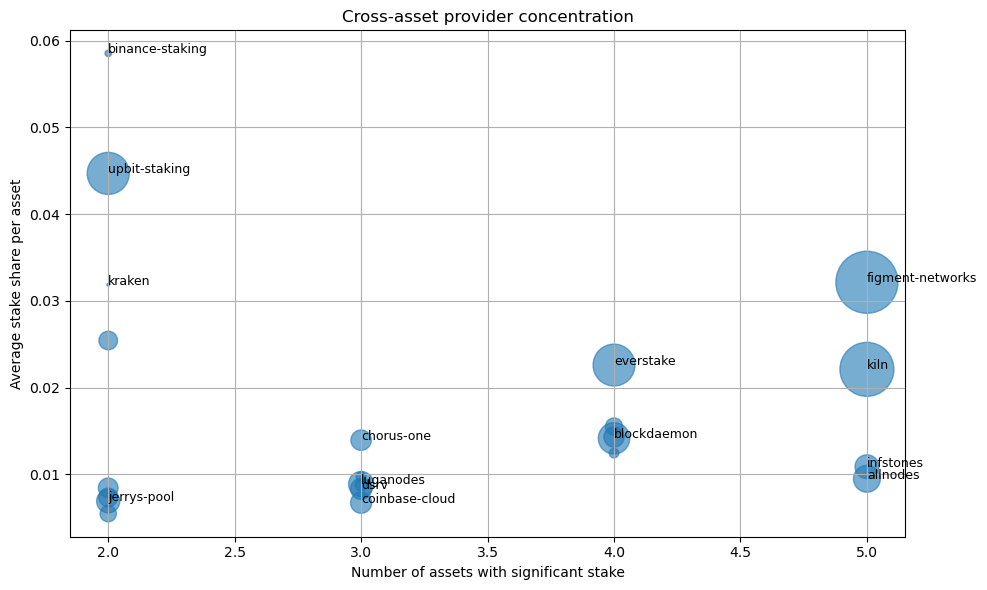

In [15]:
import matplotlib.pyplot as plt

# Optional but recommended for readable, non-overlapping labels
USE_ADJUST_TEXT = True
try:
    from adjustText import adjust_text
except Exception:
    USE_ADJUST_TEXT = False

fig, ax = plt.subplots(figsize=(10, 6))

# Bubble sizes
size = (
    provider_cross["total_effective_stake"]
    / provider_cross["total_effective_stake"].max()
    * 2000
)

ax.scatter(
    provider_cross["assets_present"],
    provider_cross["mean_asset_share"],
    s=size,
    alpha=0.6,
)

# ---- label strategy: label only "important" providers ----
TOP_N_BY_TOTAL = 12
label_providers = set(
    provider_cross.nlargest(TOP_N_BY_TOTAL, "total_effective_stake")["provider"]
)

# also label providers with broad presence or high average share
label_providers |= set(
    provider_cross[
        (provider_cross["assets_present"] >= 6) |
        (provider_cross["mean_asset_share"] >= 0.03)
    ]["provider"]
)

texts = []
for _, row in provider_cross.iterrows():
    if row["provider"] not in label_providers:
        continue

    # place label initially at the point (adjustText will move it if available)
    t = ax.text(
        row["assets_present"],
        row["mean_asset_share"],
        row["provider"],
        fontsize=9
    )
    texts.append(t)

# de-overlap labels if adjustText is available
if USE_ADJUST_TEXT and texts:
    adjust_text(
        texts,
        ax=ax,
        expand_points=(1.2, 1.2),
        expand_text=(1.2, 1.2),
        arrowprops=dict(arrowstyle="-", lw=0.4, alpha=0.7),
    )

ax.set_xlabel("Number of assets with significant stake")
ax.set_ylabel("Average stake share per asset")
ax.set_title("Cross-asset provider concentration")
ax.grid(True)

fig.tight_layout()

fig.savefig(
    "figures/cross_asset_bubble.pdf",
    format="pdf",
    bbox_inches="tight",
)

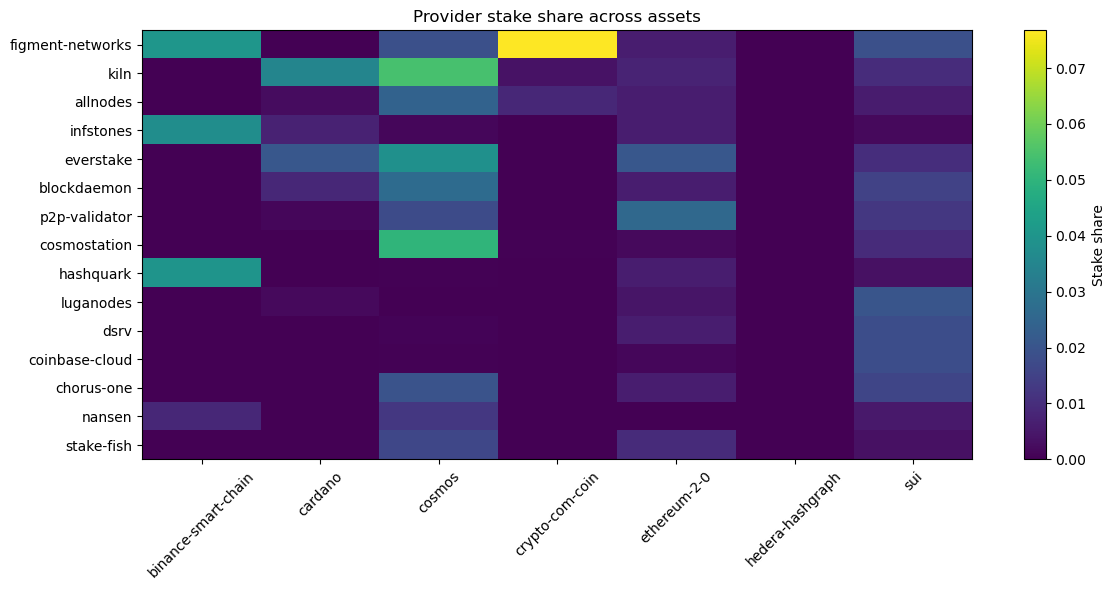

In [16]:
pivot = provider_asset_df.pivot_table(
    index="provider",
    columns="asset",
    values="stake_share_in_asset",
    aggfunc="max",
    fill_value=0.0,
)

# focus on top providers
top_providers = (
    provider_cross
    .head(15)["provider"]
)

pivot = pivot.loc[top_providers]

plt.figure(figsize=(12, 6))
plt.imshow(pivot, aspect="auto")
plt.colorbar(label="Stake share")
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=45)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.title("Provider stake share across assets")
plt.tight_layout()
plt.show()


In [17]:
import matplotlib.pyplot as plt

def plot_lorenz_curve(
    providers: list[dict],
    total_value: float,
    split_residual: bool = True,
    min_residual_token_amount: float = 1.0,
    ax=None,
    title: str = "Lorenz curve",
):
    """
    Plot a Lorenz curve from absolute staking values.

    Args:
        providers: List of provider dicts
        total_value: Total staking amount for the network
        split_residual: If True, split residual into min token chunks. If False, use one residual blob.
        min_residual_token_amount: Minimum chunk size for residual splitting
        ax: Optional matplotlib axes
        title: Plot title

    Returns:
        matplotlib Axes
    """
    if total_value <= 0:
        raise ValueError("total_value must be > 0")

    values, _, _ = _build_stake_values_with_residual(
        providers=providers,
        total_value=total_value,
        split_residual=split_residual,
        min_residual_token_amount=min_residual_token_amount,
    )

    if not values:
        raise ValueError("No positive staking values after residual handling")

    values.sort()
    n = len(values)
    total = sum(values)

    cumulative_value_share = [0.0]
    running = 0.0
    for v in values:
        running += v
        cumulative_value_share.append(running / total)

    cumulative_entity_share = [i / n for i in range(0, n + 1)]

    area = 0.0
    for i in range(1, len(cumulative_entity_share)):
        width = cumulative_entity_share[i] - cumulative_entity_share[i - 1]
        height = (
            cumulative_value_share[i] + cumulative_value_share[i - 1]
        ) / 2
        area += width * height

    gini = 1.0 - 2.0 * area
    gini = max(0.0, min(1.0, gini))

    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))

    ax.plot(
        cumulative_entity_share,
        cumulative_value_share,
        label="Lorenz curve",
    )
    ax.plot([0, 1], [0, 1], "k--", label="Equality")
    ax.fill_between(
        cumulative_entity_share,
        cumulative_value_share,
        cumulative_entity_share,
        alpha=0.1,
    )

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Cumulative share of providers")
    ax.set_ylabel("Cumulative share of staked tokens")
    ax.set_title(title)
    ax.legend()
    ax.text(
        0.6,
        0.1,
        f"Gini: {gini:.3f}",
        transform=ax.transAxes,
    )

    return ax

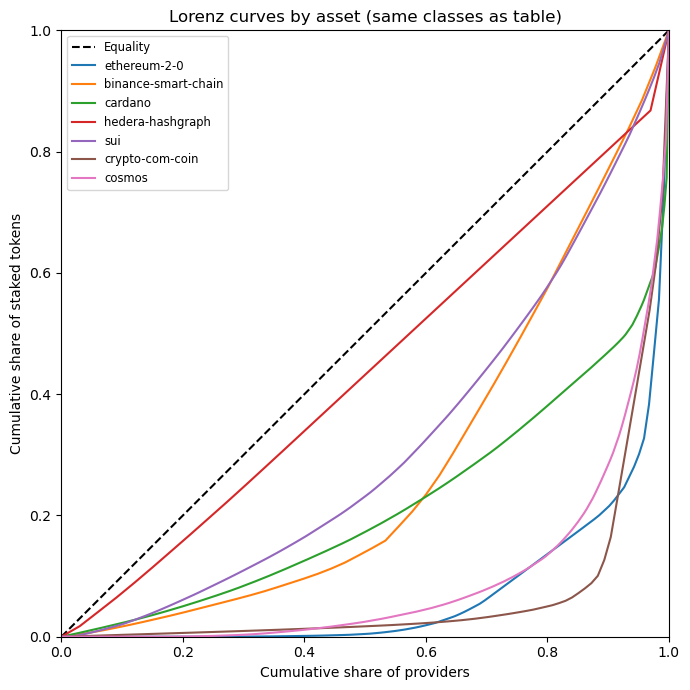

In [18]:
## Combined lorenz curve

def add_lorenz_curve_to_axis(
    ax,
    providers: list[dict],
    total_value: float,
    label: str,
    split_residual: bool = False,
    min_residual_token_amount: float = 1.0,
):
    values, _, _ = _build_stake_values_with_residual(
        providers=providers,
        total_value=total_value,
        split_residual=split_residual,
        min_residual_token_amount=min_residual_token_amount,
    )

    if not values:
        return

    values.sort()
    n = len(values)
    total = sum(values)

    y = [0.0]
    running = 0.0
    for v in values:
        running += v
        y.append(running / total)

    x = [i / n for i in range(0, n + 1)]

    ax.plot(x, y, label=label)

import matplotlib.pyplot as plt

# For Lorenz/Gini plots, a single residual blob is usually less distortionary.
LORENZ_SPLIT_RESIDUAL = False
LORENZ_MIN_RESIDUAL_TOKEN_AMOUNT = 1.0

fig, ax = plt.subplots(figsize=(7, 7))

ax.plot([0, 1], [0, 1], "k--", label="Equality")

for asset in df["asset"]:
    data = lorenz_inputs.get(asset)
    if not data:
        continue

    add_lorenz_curve_to_axis(
        ax=ax,
        providers=data["providers"],
        total_value=data["total_value"],
        label=asset,
        split_residual=LORENZ_SPLIT_RESIDUAL,
        min_residual_token_amount=LORENZ_MIN_RESIDUAL_TOKEN_AMOUNT,
    )

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel("Cumulative share of providers")
ax.set_ylabel("Cumulative share of staked tokens")
ax.set_title("Lorenz curves by asset (same classes as table)")
ax.legend(loc="upper left", fontsize="small")

plt.tight_layout()

plt.savefig(
    "figures/lorenz_curve.pdf",
    format="pdf",
    bbox_inches="tight",
)



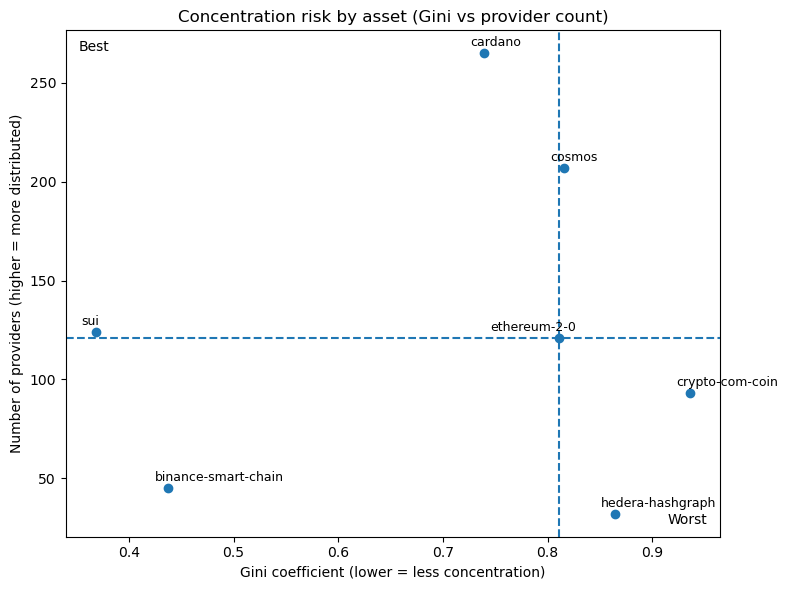

In [19]:
# Quadrant scatter plot
import matplotlib.pyplot as plt

MIN_COVERAGE_INCLUDED = 0.75
METRIC = "gini"

df_filtered = df[df["coverage_included"] >= MIN_COVERAGE_INCLUDED]

# choose quadrant split points
x_cut = df_filtered[METRIC].median()          # vertical line (gini)
y_cut = df_filtered["provider_count"].median() # horizontal line (providers)

fig, ax = plt.subplots(figsize=(8, 6))

# scatter
ax.scatter(df_filtered[METRIC], df_filtered["provider_count"])

# label points
OFFSETS = {
    "tezos": (5, -10),
    "ethereum-2-0": (-50, 5),
}

DEFAULT_OFFSET = (-10, 5)

for _, r in df_filtered.iterrows():
    ax.annotate(
        r["asset"],
        (r[METRIC], r["provider_count"]),
        xytext=OFFSETS.get(r["asset"], DEFAULT_OFFSET),
        textcoords="offset points",
        fontsize=9,
    )

# quadrant lines
ax.axvline(x_cut, linestyle="--")
ax.axhline(y_cut, linestyle="--")

# axis labels / title
ax.set_xlabel("Gini coefficient (lower = less concentration)")
ax.set_ylabel("Number of providers (higher = more distributed)")
ax.set_title("Concentration risk by asset (Gini vs provider count)")

# optional: annotate quadrants
ax.text(0.02, 0.98, "Best", transform=ax.transAxes,
        va="top")
ax.text(0.98, 0.02, "Worst", transform=ax.transAxes,
        ha="right", va="bottom")

plt.tight_layout()
#plt.show()

#plt.tight_layout()

plt.savefig(
    "figures/provider_concentration_scatter.pdf",
    format="pdf",
    bbox_inches="tight",
)

In [10]:
assets = [
    "ethereum-2-0",
    "binance-smart-chain",
    "solana",
    "cardano", 
    "waves", 
    "cosmos", 
    "avalanche", 
    "hyperliquid",
    "tron",
    "sui",
    "bittensor",
    "hedera-hashgraph",
    "aptos",
    "crypto-com-coin",
    "near-protocol",
    "story-network",
    "sei-network",
    "stacks",
    "tezos",
    "monad",
    "injective-protocol",
    "algorand",
    "celestia",
    "iota",
    "aleo",
    "fetch-ai",
    "starknet"
]

assets_on_rated = [
    "solana",
    "cardano",
    "celestia",
    "ethereum-2-0",
    "matic-network", # Polygon
    "avalanche",
    "polkadot",
    "cosmos",
    "eigenlayer",
    "babylon"
]

In [5]:
import math
from typing import Optional
import matplotlib.pyplot as plt
import numpy as np

def _extract_points(stake_shares_response):
    """
    Extract (stake, reward_rate) pairs from get_provider_stake_shares response.

    Returns a list of (stake, reward_rate) tuples with both values present and > 0.
    """
    providers = stake_shares_response.get("providers") or []
    points = []
    for p in providers:
        stake = p.get("staked_tokens")
        rr = p.get("reward_rate")
        if stake is None or rr is None:
            continue
        try:
            stake_val = float(stake)
            rr_val = float(rr)
        except (TypeError, ValueError):
            continue
        if stake_val <= 0 or rr_val <= 0:
            continue
        points.append((stake_val, rr_val))
    return points

def plot_reward_rate_vs_stake(stake_shares_response, ax: Optional[plt.Axes] = None, title: Optional[str] = None, logx: bool = True, logy: bool = True):
    """
    Scatter + simple regression line for reward_rate vs staked_tokens.

    Args:
        stake_shares_response (dict): Response from get_provider_stake_shares
        ax (matplotlib.axes.Axes, optional): Axis to draw on; creates a new one if None.
        title (str, optional): Plot title.
        logx (bool, optional): Log scale for x (stake). Default True.
        logy (bool, optional): Log scale for y (reward rate). Default True.

    Returns:
        matplotlib.axes.Axes: The axis with the plot.

    Raises:
        ValueError: If fewer than two data points are available.
    """
    points = _extract_points(stake_shares_response)
    if len(points) < 2:
        raise ValueError("Need at least two providers with staked_tokens and reward_rate to plot regression.")

    stakes, reward_rates = zip(*points)
    stakes = np.array(stakes)
    reward_rates = np.array(reward_rates)

    ax = ax or plt.subplots(figsize=(7, 5))[1]
    ax.scatter(stakes, reward_rates, alpha=0.6, label="providers")

    # Regression on log-transformed data for robustness across magnitudes
    log_stakes = np.log(stakes)
    log_rr = np.log(reward_rates)
    slope, intercept = np.polyfit(log_stakes, log_rr, 1)
    fitted = np.exp(intercept) * stakes ** slope
    ax.plot(stakes, fitted, color="orange", label=f"fit: y = {math.exp(intercept):.3g} * x^{slope:.2f}")

    if logx:
        ax.set_xscale("log")
    if logy:
        ax.set_yscale("log")

    ax.set_xlabel("Staked tokens")
    ax.set_ylabel("Reward rate")
    if title:
        ax.set_title(title)
    ax.legend()
    ax.grid(True, which="both", ls="--", alpha=0.3)
    return ax


[4.953185270935226, 6.761219116716955, 5.128081087990655, 5.256890011279049, 5.550113603217018, 5.431166354749563, 4.24300561625051, 4.411465803506631, 5.003914779061452, 5.2012582753192005, 5.423108847985717, 5.09914598922659, 5.105361022081788, 6.338983941539193, 1.8889619184576987, 5.099970164425405, 5.593614233376213, 5.101823024693363, 5.100430465057795, 5.102958560636557, 4.535838127273348, 5.102154190077619, 5.624783903478171, 5.260890946450333, 5.1036233663927355, 5.4250281960920725, 5.540664518998523]


<Axes: title={'center': 'Provider staked token for avalanche'}, xlabel='Staked tokens', ylabel='Reward rate'>

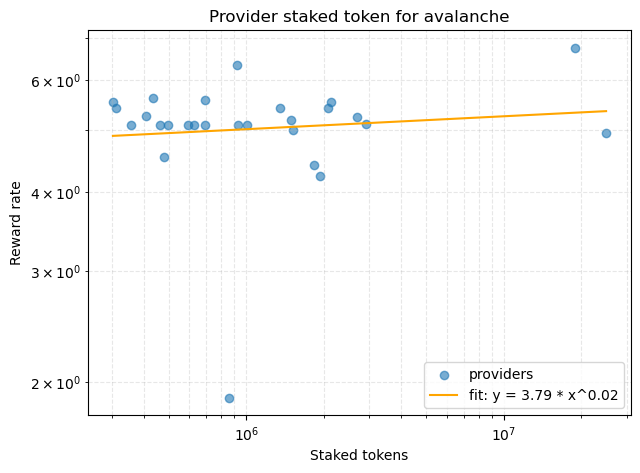

In [50]:
asset_slug=assets[6]
resp = client.get_provider_stake_shares(asset_slug=asset_slug, limit=200, is_active=True, include_reward_rate=True)
print([prov["reward_rate"] for prov in resp["providers"]])
plot_reward_rate_vs_stake(resp, title=f"Provider staked token for {asset_slug}")

In [10]:
import pandas as pd


def gini_from_stake_response(resp):
    """
    Compute Gini coefficient from get_provider_stake_shares response
    using the unified residual-aware implementation.
    """
    providers = resp.get("providers") or []
    total_value = resp.get("total_staked_tokens")
    if total_value in (None, 0):
        return None

    try:
        total_value = float(total_value)
    except (TypeError, ValueError):
        return None

    return calculate_gini_from_values(
        providers,
        total_value,
        split_residual=False,
        min_residual_token_amount=1.0,
    )


def weighted_average_reward_rate(providers):
    weighted_sum = 0.0
    total_weight = 0.0
    for p in providers:
        rr = p.get("reward_rate")
        stake = p.get("staked_tokens")
        if rr is None or stake in (None, 0):
            continue
        try:
            rr_val = float(rr)
            stake_val = float(stake)
        except (TypeError, ValueError):
            continue
        weighted_sum += rr_val * stake_val
        total_weight += stake_val
    if total_weight == 0:
        return None
    return weighted_sum / total_weight


rows = []
for asset_slug in assets:
    resp = client.get_provider_stake_shares(asset_slug=asset_slug, limit=200, is_active=True, include_reward_rate=True)
    providers = resp.get("providers") or []
    rows.append({
        "asset": asset_slug,
        "gini_coefficient": gini_from_stake_response(resp),
        "total_staked_tokens": resp.get("total_staked_tokens"),
        "uncovered_staking_part": resp.get("untracked_share"),
        "average_reward_rate": weighted_average_reward_rate(providers),
    })

summary_df = pd.DataFrame(rows)
summary_df



,asset,gini_coefficient,total_staked_tokens,uncovered_staking_part,average_reward_rate
0,ethereum-2-0,0.891494,3.569411e+07,NaN,3.876372
1,binance-smart-chain,0.412434,2.542967e+07,0.000000e+00,0.498212
2,solana,0.575564,4.138471e+08,5.730493e-01,6.352880
3,cardano,0.362558,2.101982e+10,3.556190e-01,2.376221
4,waves,0.761370,2.166231e+07,2.494765e-01,5.655753
5,cosmos,0.791212,2.854351e+08,NaN,16.924993
6,avalanche,0.676533,2.085705e+08,6.575791e-01,5.470428
7,hyperliquid,0.827883,4.311673e+08,NaN,2.153416
8,tron,0.287679,4.331291e+10,4.686949e-02,3.142734
9,sui,0.375899,7.478759e+09,NaN,1.833501


In [12]:
import json
import pandas as pd

asset_slug = "avalanche"

resp = client.get_provider_stake_shares(
    asset_slug=asset_slug,
    limit=200,
    is_active=True,
    include_reward_rate=True,
)
providers = resp.get("providers") or []

query = f"""
{{
  rewardOptions(
    where: {{ inputAsset: {{ slugs: [{json.dumps(asset_slug)}] }} }}
    limit: 200
    order: {{ metricKey_desc: "staked_tokens" }}
  ) {{
    providers(limit: 1) {{ slug name }}
    type {{ key label }}
  }}
}}
"""
type_result = client.execute_raw_query(query)
provider_types = {}
for ro in type_result.get("data", {}).get("rewardOptions", []) or []:
    prov = (ro.get("providers") or [{}])[0]
    slug = prov.get("slug")
    stake_type = None
    ro_type = ro.get("type")
    if ro_type:
        stake_type = ro_type.get("label") or ro_type.get("key")
    if slug and slug not in provider_types:
        provider_types[slug] = stake_type

rows = []
for p in providers:
    slug = p.get("provider")
    rows.append({
        "provider": p.get("name") or slug,
        "staked_tokens": p.get("staked_tokens"),
        "percentage_of_total": (p.get("share") * 100) if p.get("share") is not None else None,
        "staking_type": provider_types.get(slug),
        "reward_rate": p.get("reward_rate"),
    })

df = pd.DataFrame(rows)
df = df.sort_values(by="percentage_of_total", ascending=False).reset_index(drop=True)
df



,provider,staked_tokens,percentage_of_total,staking_type,reward_rate
0,BENQI Liquid Staking,2.495062e+07,11.962683,liquid-staking,4.953185
1,Allnodes,1.892855e+07,9.075374,hosting,6.761219
2,GoGoPool,2.925044e+06,1.402425,liquid-staking,5.128081
3,091,2.700000e+06,1.294527,pos,5.256890
4,060,2.136406e+06,1.024309,pos,5.550114
5,059,2.078923e+06,0.996749,pos,5.431166
6,Kiln,1.937723e+06,0.929050,pos,4.243006
7,081,1.837000e+06,0.880758,pos,4.411466
8,085,1.512055e+06,0.724961,pos,5.003915
9,086,1.498000e+06,0.718223,pos,5.201258
